In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

df = pd.read_csv(r"D:\Doni Study\DataPortfolio\Forage_Simulations\Quantium-stimulation\QVI_data.csv")

In [5]:
df.columns

Index(['LYLTY_CARD_NBR', 'DATE', 'STORE_NBR', 'TXN_ID', 'PROD_NBR',
       'PROD_NAME', 'PROD_QTY', 'TOT_SALES', 'PACK_SIZE', 'BRAND', 'LIFESTAGE',
       'PREMIUM_CUSTOMER'],
      dtype='object')

In [8]:
#Convert 'DATE' to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

#Create a 'month' column
df['month'] = df['DATE'].dt.to_period('M')

#Group by Store and Month
monthly_metrics = df.groupby(['STORE_NBR', 'month']).agg({
    'TOT_SALES': 'sum',
    'LYLTY_CARD_NBR': pd.Series.nunique,
    'TXN_ID': 'count'
}).reset_index()

#Rename Columns
monthly_metrics.rename(columns={
    'TOT_SALES': 'total_sales',
    'LYLTY_CARD_NBR': 'num_customers',
    'TXN_ID': 'num_transactions',
    'STORE_NBR': 'store_id'
}, inplace=True)

#Calculate Transactions per Customer
monthly_metrics['transactions_per_customer'] = (
    monthly_metrics['num_transactions'] / monthly_metrics['num_customers']
)

monthly_metrics.head()

,store_id,month,total_sales,num_customers,num_transactions,transactions_per_customer
0,1,2018-07,206.9,49,52,1.061224
1,1,2018-08,176.1,42,43,1.023810
2,1,2018-09,278.8,59,62,1.050847
3,1,2018-10,188.1,44,45,1.022727
4,1,2018-11,192.6,46,47,1.021739


In [13]:
#Pre trial period
pre_trial = monthly_metrics[monthly_metrics['month'] < '2019-02']

In [14]:
#stores that appear in every month
store_month_counts = pre_trial.groupby('store_id')['month'].nunique()
full_period_stores = store_month_counts[store_month_counts == store_month_counts.max()].index

In [15]:
#Filter Monthly Metrics to These Stores
pre_trial_filtered = pre_trial[pre_trial['store_id'].isin(full_period_stores)]

In [19]:
from scipy.stats import pearsonr

def compare_store(trial_store_id, metric):
    trial_data = pre_trial_filtered[pre_trial_filtered['store_id'] == trial_store_id][metric].reset_index(drop=True)
    scores = []

    for store_id in pre_trial_filtered['store_id'].unique():
        if store_id == trial_store_id:
            continue
        control_data = pre_trial_filtered[pre_trial_filtered['store_id'] == store_id][metric].reset_index(drop=True)

        # Align lengths
        min_len = min(len(trial_data), len(control_data))
        trial_slice = trial_data[:min_len]
        control_slice = control_data[:min_len]

        # Skip if constant
        if trial_slice.nunique() <= 1 or control_slice.nunique() <= 1:
            continue

        score = pearsonr(trial_slice, control_slice)[0]
        scores.append((store_id, score))

    return sorted(scores, key=lambda x: -x[1])

sales_matches_77 = compare_store(77, 'total_sales')
sales_matches_77[:5]  # Show top 5 matches

[(np.int64(71), np.float64(0.9141059654434731)),
 (np.int64(233), np.float64(0.9037741879865313)),
 (np.int64(119), np.float64(0.8676644040124436)),
 (np.int64(17), np.float64(0.8426683602788767)),
 (np.int64(3), np.float64(0.8066436365226516))]

[(71, 0.914), (233, 0.904), (119, 0.868), (17, 0.843), (3, 0.807)]

Store 71 has the highest correlation with store 77 — so it’s your best control store for this metric.


In [20]:
customer_matches_77 = compare_store(77, 'num_customers')
txn_matches_77 = compare_store(77, 'transactions_per_customer')

customer_matches_77[:5]
txn_matches_77[:5]

[(np.int64(176), np.float64(0.8760526150292577)),
 (np.int64(144), np.float64(0.8561467798933686)),
 (np.int64(86), np.float64(0.8153345733102846)),
 (np.int64(118), np.float64(0.7981669375767875)),
 (np.int64(248), np.float64(0.7630272705995468))]

In [23]:
#Run for store 86

sales_matches_86 = compare_store(86, 'total_sales')
customer_matches_86 = compare_store(86, 'num_customers')
txn_matches_86 = compare_store(86, 'transactions_per_customer')

# View top matches
print("Sales:", sales_matches_86[:5],"\n")
print("Customers:", customer_matches_86[:5],"\n")
print("Transactions:", txn_matches_86[:5],"\n")

Sales: [(np.int64(155), np.float64(0.8778816901365498)), (np.int64(132), np.float64(0.8465165640013178)), (np.int64(240), np.float64(0.8250658384874218)), (np.int64(222), np.float64(0.7950752986301441)), (np.int64(109), np.float64(0.788299539592691))] 

Customers: [(np.int64(155), np.float64(0.9428756256686044)), (np.int64(114), np.float64(0.8553390499905142)), (np.int64(260), np.float64(0.8465019549963757)), (np.int64(176), np.float64(0.7963798466198578)), (np.int64(109), np.float64(0.7707780469374135))] 

Transactions: [(np.int64(118), np.float64(0.8912594724823315)), (np.int64(13), np.float64(0.8848210815915369)), (np.int64(244), np.float64(0.8696464278356433)), (np.int64(144), np.float64(0.837250983917323)), (np.int64(22), np.float64(0.8335782263008245))] 



In [26]:
#Run for store 88

sales_matches_88 = compare_store(88, 'total_sales')
customer_matches_88 = compare_store(88, 'num_customers')
txn_matches_88 = compare_store(88, 'transactions_per_customer')

# View top matches
print("Sales:", sales_matches_88[:5],"\n")
print("Customers:", customer_matches_88[:5],"\n")
print("Transactions:", txn_matches_88[:5],"\n")

Sales: [(np.int64(159), np.float64(0.9031855640409738)), (np.int64(204), np.float64(0.885774218439864)), (np.int64(134), np.float64(0.8642934799118711)), (np.int64(1), np.float64(0.813636047784386)), (np.int64(253), np.float64(0.8118377088858145))] 

Customers: [(np.int64(237), np.float64(0.9473262390629102)), (np.int64(14), np.float64(0.9429761679659832)), (np.int64(178), np.float64(0.939466041693001)), (np.int64(35), np.float64(0.8995936151600288)), (np.int64(113), np.float64(0.8626323509003309))] 

Transactions: [(np.int64(24), np.float64(0.8389890268345358)), (np.int64(137), np.float64(0.828816292707782)), (np.int64(272), np.float64(0.8027016967997676)), (np.int64(243), np.float64(0.7630435433711259)), (np.int64(201), np.float64(0.7607184418637815))] 



Methodology:
Control stores were selected based on similarity to trial stores across three key metrics:
- Monthly total sales revenue
- Monthly number of customers
- Monthly transactions per customer

Pearson correlation was used to compare each trial store to all other stores that were operational throughout the pre-trial period (before Feb 2019).

Final Control Store Matches:
- Trial Store 77 → Control Store 71
- Trial Store 86 → Control Store 155
- Trial Store 88 → Control Store 237

These stores showed the highest similarity across multiple metrics, ensuring reliable baseline comparisons.

In [28]:
#Extract and label store Data
def get_store_metrics(store_id, label):
    df = pre_trial_filtered[pre_trial_filtered['store_id'] == store_id].copy()
    df['store_type'] = label
    return df

# Trial vs Control pairs
store_77 = get_store_metrics(77, 'Trial 77')
control_71 = get_store_metrics(71, 'Control 71')

store_86 = get_store_metrics(86, 'Trial 86')
control_155 = get_store_metrics(155, 'Control 155')

store_88 = get_store_metrics(88, 'Trial 88')
control_237 = get_store_metrics(237, 'Control 237')

In [29]:
#Define Plot Function
import matplotlib.pyplot as plt

def plot_metric(trial_df, control_df, metric, title):
    combined = pd.concat([trial_df, control_df])
    pivot = combined.pivot(index='month', columns='store_type', values=metric)

    pivot.plot(figsize=(10, 5), marker='o')
    plt.title(title)
    plt.ylabel(metric.replace('_', ' ').title())
    plt.xlabel('Month')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

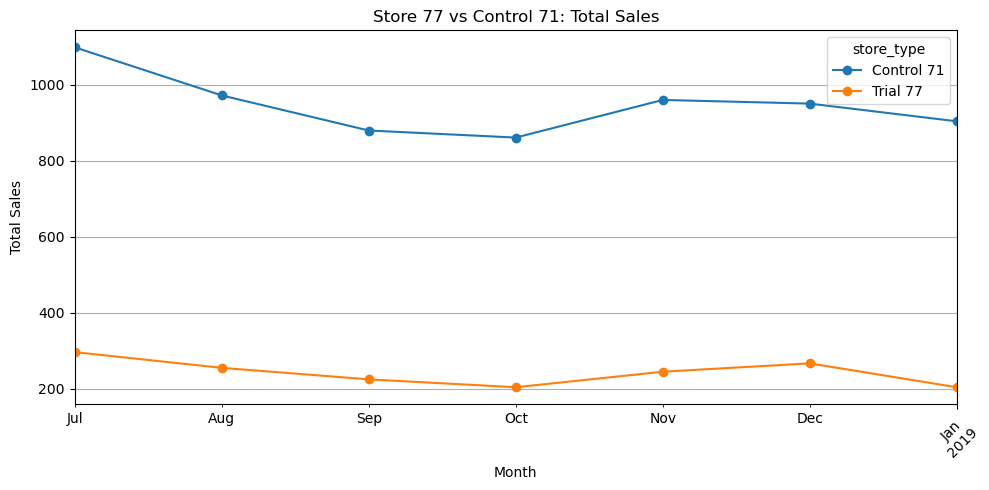

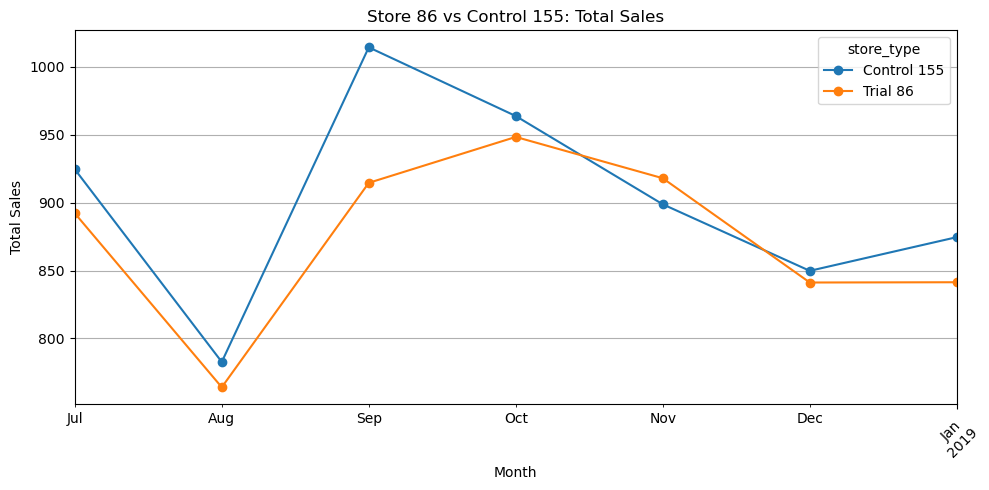

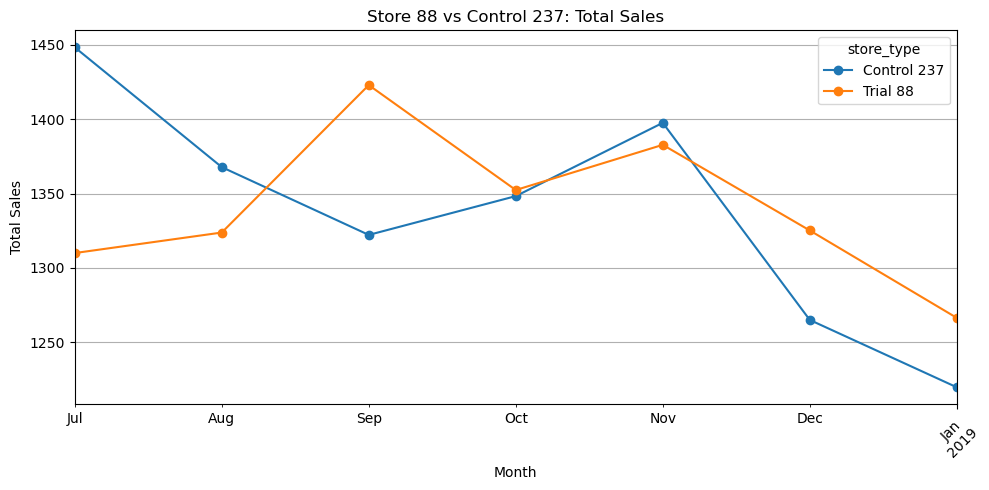

In [30]:
#Plot Total sales
plot_metric(store_77, control_71, 'total_sales', 'Store 77 vs Control 71: Total Sales')
plot_metric(store_86, control_155, 'total_sales', 'Store 86 vs Control 155: Total Sales')
plot_metric(store_88, control_237, 'total_sales', 'Store 88 vs Control 237: Total Sales')

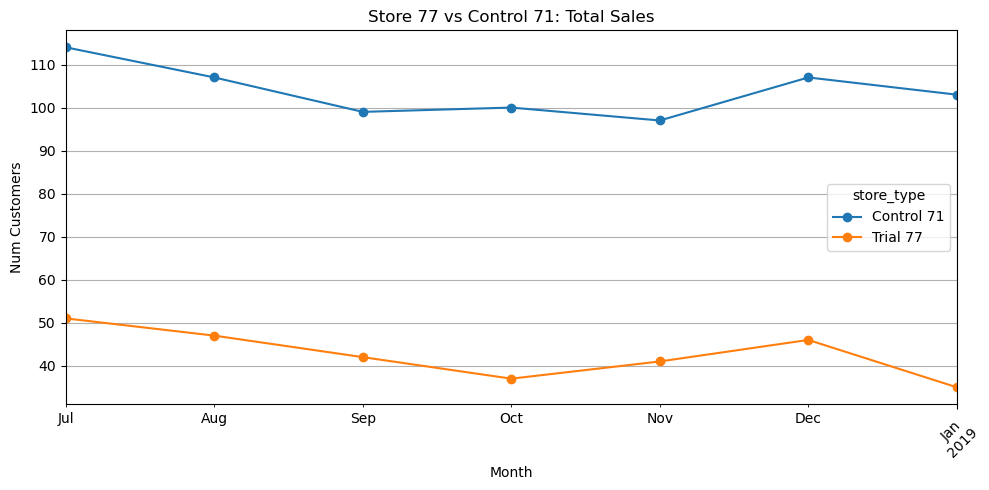

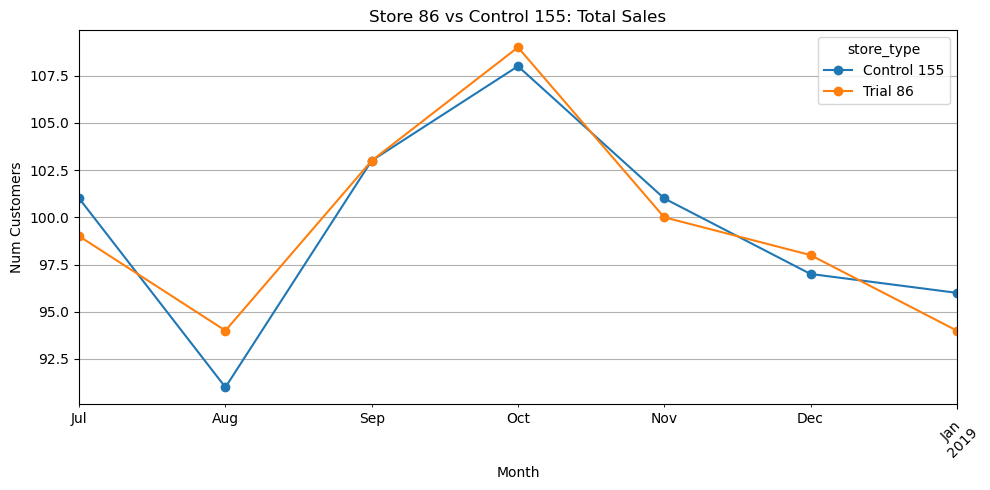

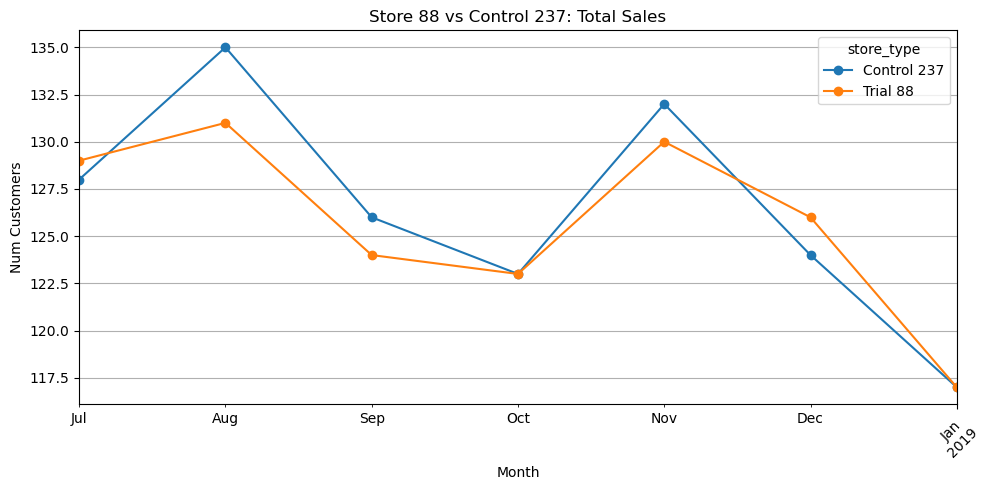

In [31]:
#Plot num_customers
plot_metric(store_77, control_71, 'num_customers', 'Store 77 vs Control 71: Total Sales')
plot_metric(store_86, control_155, 'num_customers', 'Store 86 vs Control 155: Total Sales')
plot_metric(store_88, control_237, 'num_customers', 'Store 88 vs Control 237: Total Sales')

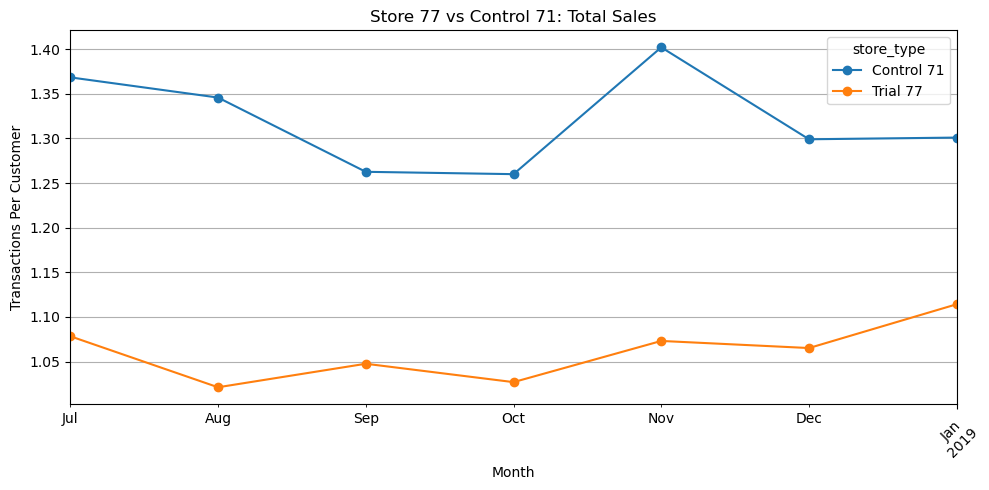

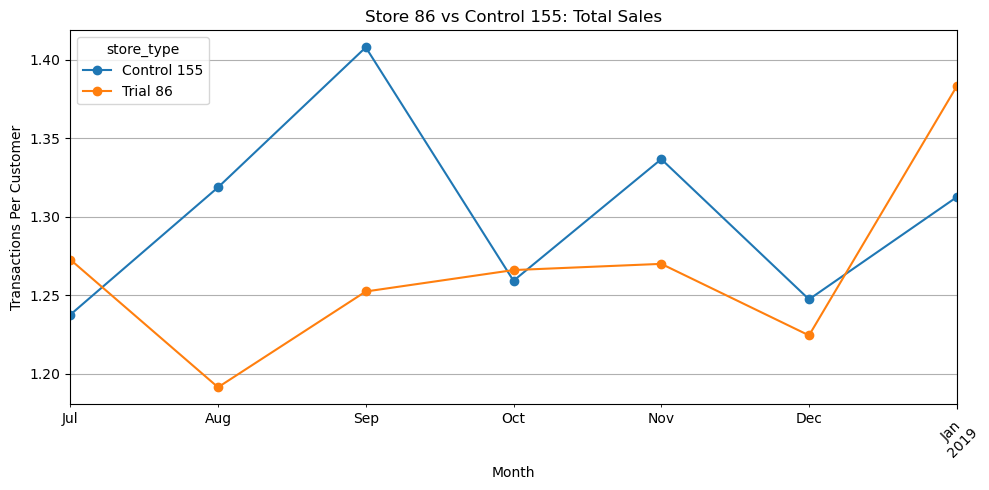

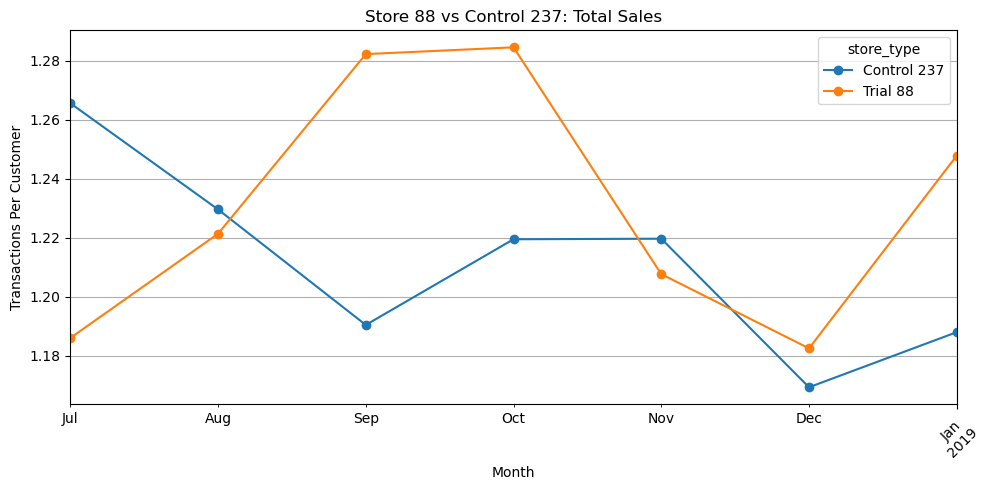

In [32]:
#Plot Total Sales
plot_metric(store_77, control_71, 'transactions_per_customer', 'Store 77 vs Control 71: Total Sales')
plot_metric(store_86, control_155, 'transactions_per_customer', 'Store 86 vs Control 155: Total Sales')
plot_metric(store_88, control_237, 'transactions_per_customer', 'Store 88 vs Control 237: Total Sales')

In [40]:
#define trial period
trial_period = (monthly_metrics['month'] >= '2019-02') & (monthly_metrics['month'] <= '2019-04')

#Extract Trial and Control Data
#store 77:
trial_77 = monthly_metrics[(monthly_metrics['store_id'] == 77) & trial_period].copy()
trial_77['store_type'] = 'Trial 77'

control_71 = monthly_metrics[(monthly_metrics['store_id'] == 71) & trial_period].copy()
control_71['store_type'] = 'Control 71'


In [42]:
#store 86:
trial_86 = monthly_metrics[(monthly_metrics['store_id'] == 86) & trial_period].copy()
trial_86['store_type'] = 'Trial 86'

control_155 = monthly_metrics[(monthly_metrics['store_id'] == 155) & trial_period].copy()
control_155['store_type'] = 'Control 155'


In [43]:
#store 88:
trial_88 = monthly_metrics[(monthly_metrics['store_id'] == 88) & trial_period].copy()
trial_88['store_type'] = 'Trial 88'

control_237 = monthly_metrics[(monthly_metrics['store_id'] == 237) & trial_period].copy()
control_237['store_type'] = 'Control 237'

In [50]:
#Trial period
trial_period = (monthly_metrics['month'] >= '2019-02') & (monthly_metrics['month'] <= '2019-04')

#Extract Trial and control data
#Store 77: 
trial_77 = monthly_metrics[(monthly_metrics['store_id'] == 77) & trial_period].copy()
control_71 = monthly_metrics[(monthly_metrics['store_id'] == 71) & trial_period].copy()
trial_77['store_type'] = 'Trial 77'
control_71['store_type'] = 'Control 71'

#Store 86: 
trial_86 = monthly_metrics[(monthly_metrics['store_id'] == 86) & trial_period].copy()
control_155 = monthly_metrics[(monthly_metrics['store_id'] == 155) & trial_period].copy()
trial_86['store_type'] = 'Trial 86'
control_155['store_type'] = 'Control 155'

#Store 88: 
trial_88 = monthly_metrics[(monthly_metrics['store_id'] == 88) & trial_period].copy()
control_237 = monthly_metrics[(monthly_metrics['store_id'] == 237) & trial_period].copy()
trial_88['store_type'] = 'Trial 88'
control_237['store_type'] = 'Control 237'

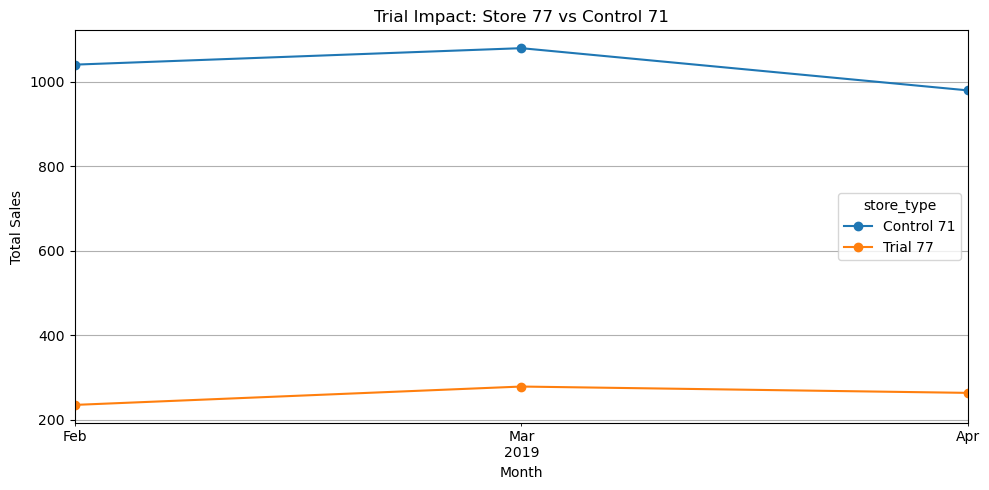

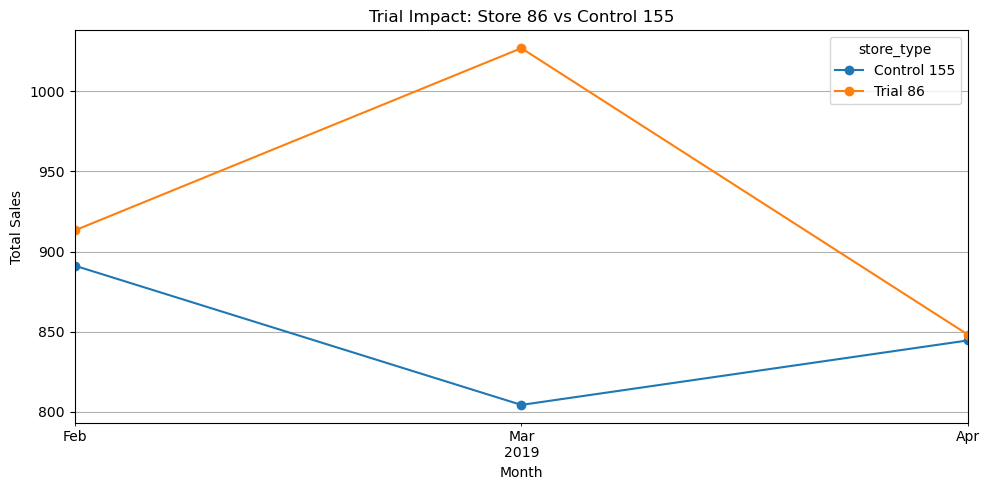

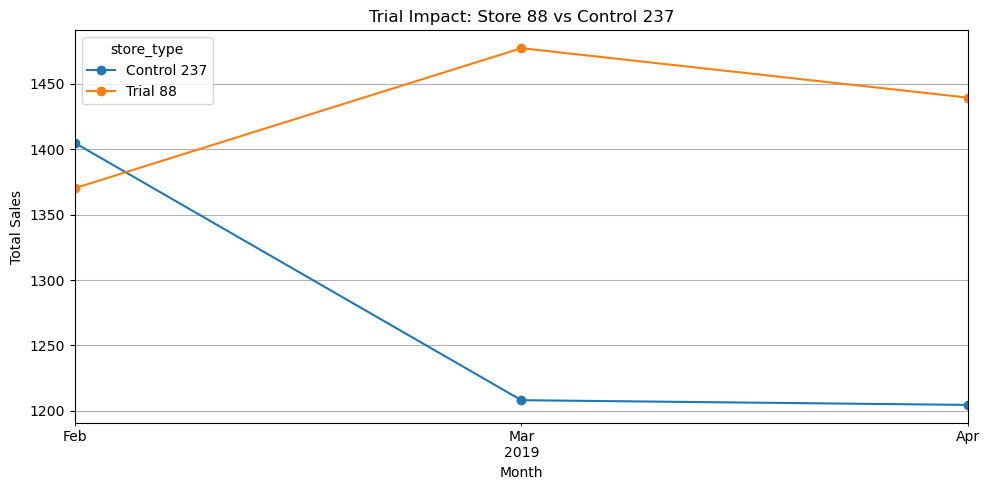

In [51]:
#Plot Trial vs Control During Trial
#Using Total sales
plot_metric(trial_77, control_71, 'total_sales', 'Trial Impact: Store 77 vs Control 71')
plot_metric(trial_86, control_155, 'total_sales', 'Trial Impact: Store 86 vs Control 155')
plot_metric(trial_88, control_237, 'total_sales', 'Trial Impact: Store 88 vs Control 237')

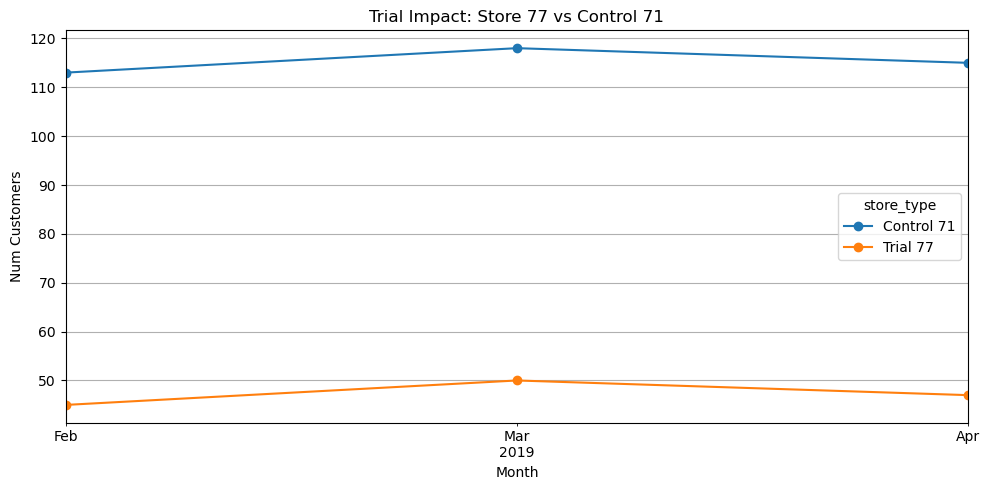

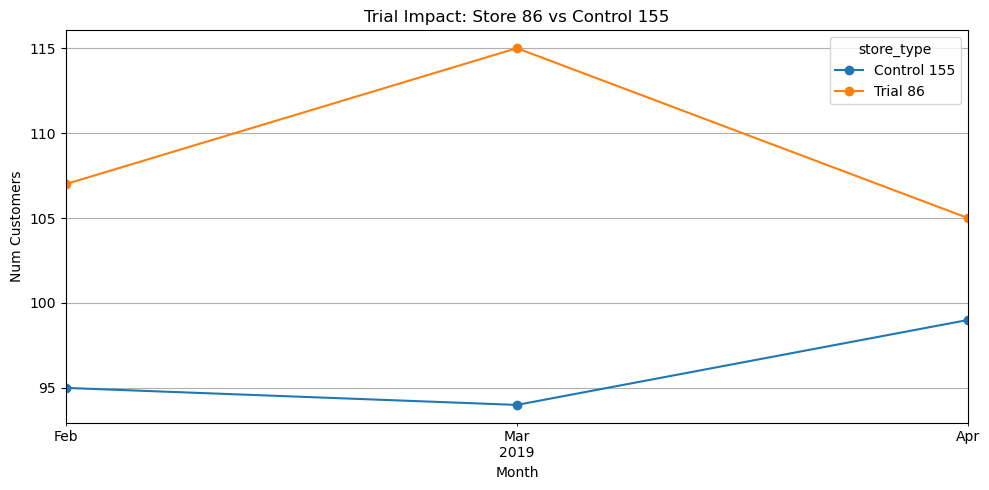

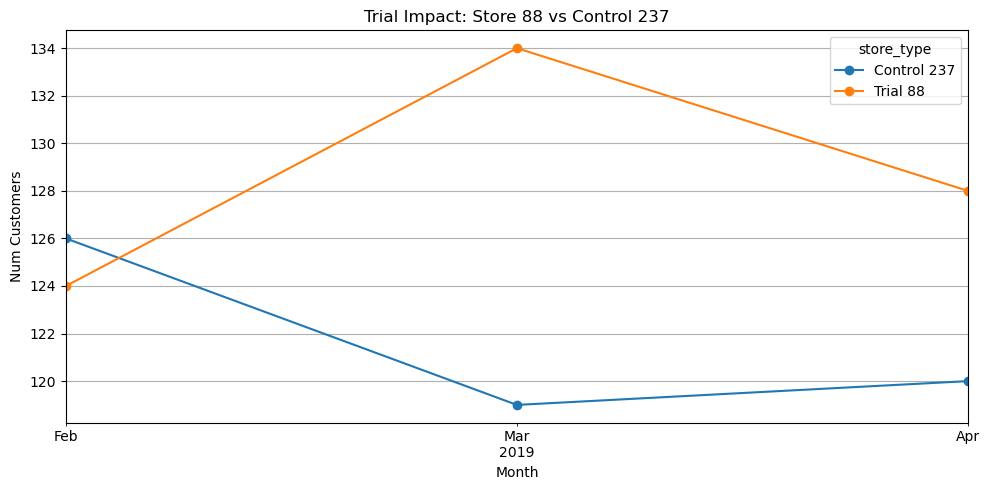

In [52]:
#Using nuber of customers
plot_metric(trial_77, control_71, 'num_customers', 'Trial Impact: Store 77 vs Control 71')
plot_metric(trial_86, control_155, 'num_customers', 'Trial Impact: Store 86 vs Control 155')
plot_metric(trial_88, control_237, 'num_customers', 'Trial Impact: Store 88 vs Control 237')

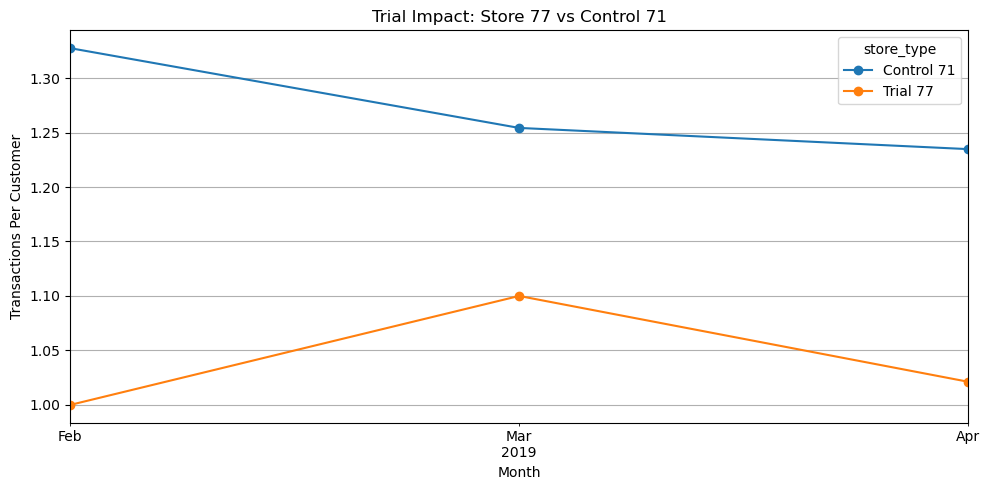

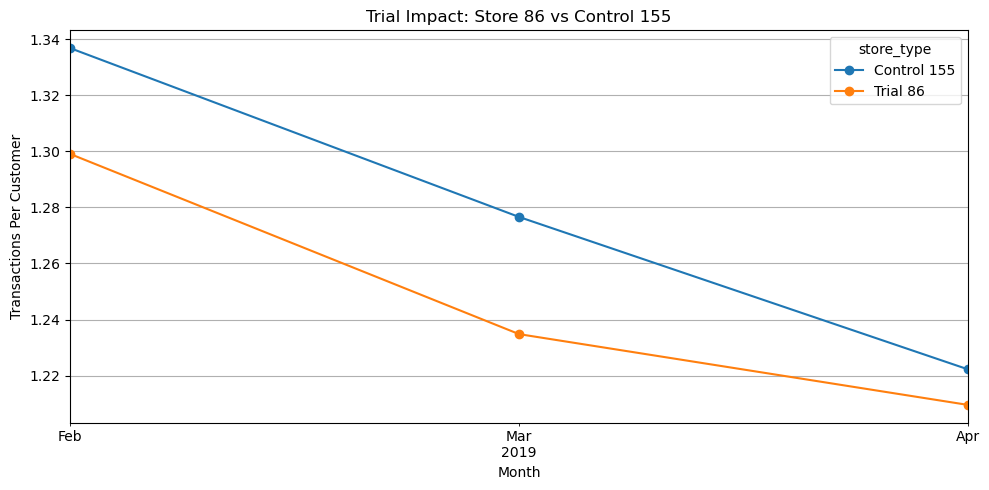

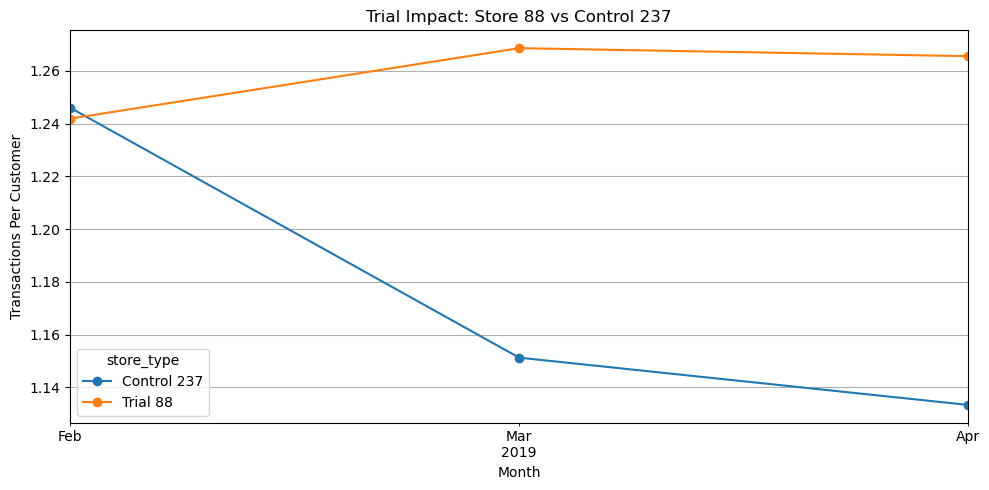

In [54]:
#using transactions of customers
plot_metric(trial_77, control_71, 'transactions_per_customer', 'Trial Impact: Store 77 vs Control 71')
plot_metric(trial_86, control_155, 'transactions_per_customer', 'Trial Impact: Store 86 vs Control 155')
plot_metric(trial_88, control_237, 'transactions_per_customer', 'Trial Impact: Store 88 vs Control 237')

In [55]:
def calculate_lift(trial_df, control_df, metric):
    trial_total = trial_df[metric].sum()
    control_total = control_df[metric].sum()
    return ((trial_total - control_total) / control_total) * 100

lift_77 = calculate_lift(trial_77, control_71, 'total_sales')
lift_86 = calculate_lift(trial_86, control_155, 'total_sales')
lift_88 = calculate_lift(trial_88, control_237, 'total_sales')

print("Lift for Store 77:", round(lift_77, 2), "%")
print("Lift for Store 86:", round(lift_86, 2), "%")
print("Lift for Store 88:", round(lift_88, 2), "%")

Lift for Store 77: -74.94 %
Lift for Store 86: 9.76 %
Lift for Store 88: 12.29 %
